In [1]:
import gmft

We will use the original paper that introduced the Table Transformer (TATR): "PubTables-1M: Towards comprehensive table extraction from unstructured documents" by Smock, Pesala, and Abraham.

In [3]:
# get the PubTables-1M paper, source of original Table Transformer (TATR)
!wget -O ../samples/2110.00061.pdf https://arxiv.org/pdf/2110.00061 

--2024-06-07 08:50:41--  https://arxiv.org/pdf/2110.00061
Resolving arxiv.org (arxiv.org)... 151.101.67.42, 151.101.195.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.67.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2636957 (2.5M) [application/pdf]
Saving to: ‘../samples/2110.00061.pdf’

../samples/2110.000 100%[===================>]   2.51M  11.7MB/s    in 0.2s    

2024-06-07 08:50:42 (11.7 MB/s) - ‘../samples/2110.00061.pdf’ saved [2636957/2636957]



In [2]:
from gmft.pdf_bindings import PyPDFium2Document
from gmft.tables import CroppedTable

detector = gmft.tables.TableDetector()

/home/conjunct/.virtualenvs/Enzy/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/conjunct/.virtualenvs/Enzy/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/conjunct/.virtualenvs/Enzy/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._

In [6]:
def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        tables += detector.extract(page)
    return tables, doc


In [7]:
tables, doc = ingest_pdf('../samples/2110.00061.pdf')
len(tables)

6

There are 6 matches. Let's view all the identified tables.

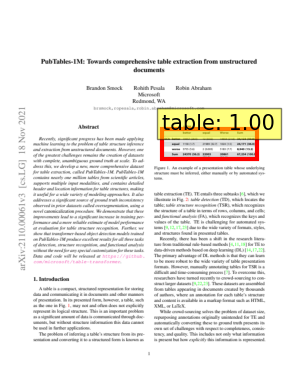

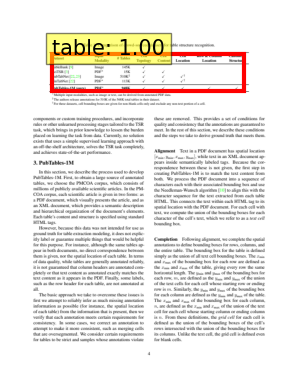

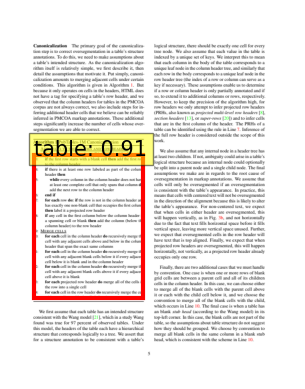

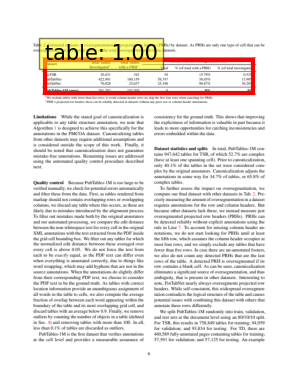

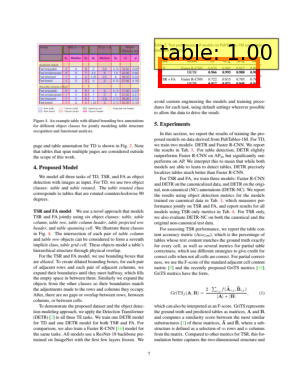

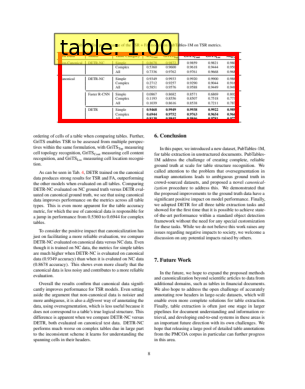

In [5]:
# display several images
# decrease size with plt
for table in tables:
    table.visualize(figsize=None)

Let's work through the tables in order.

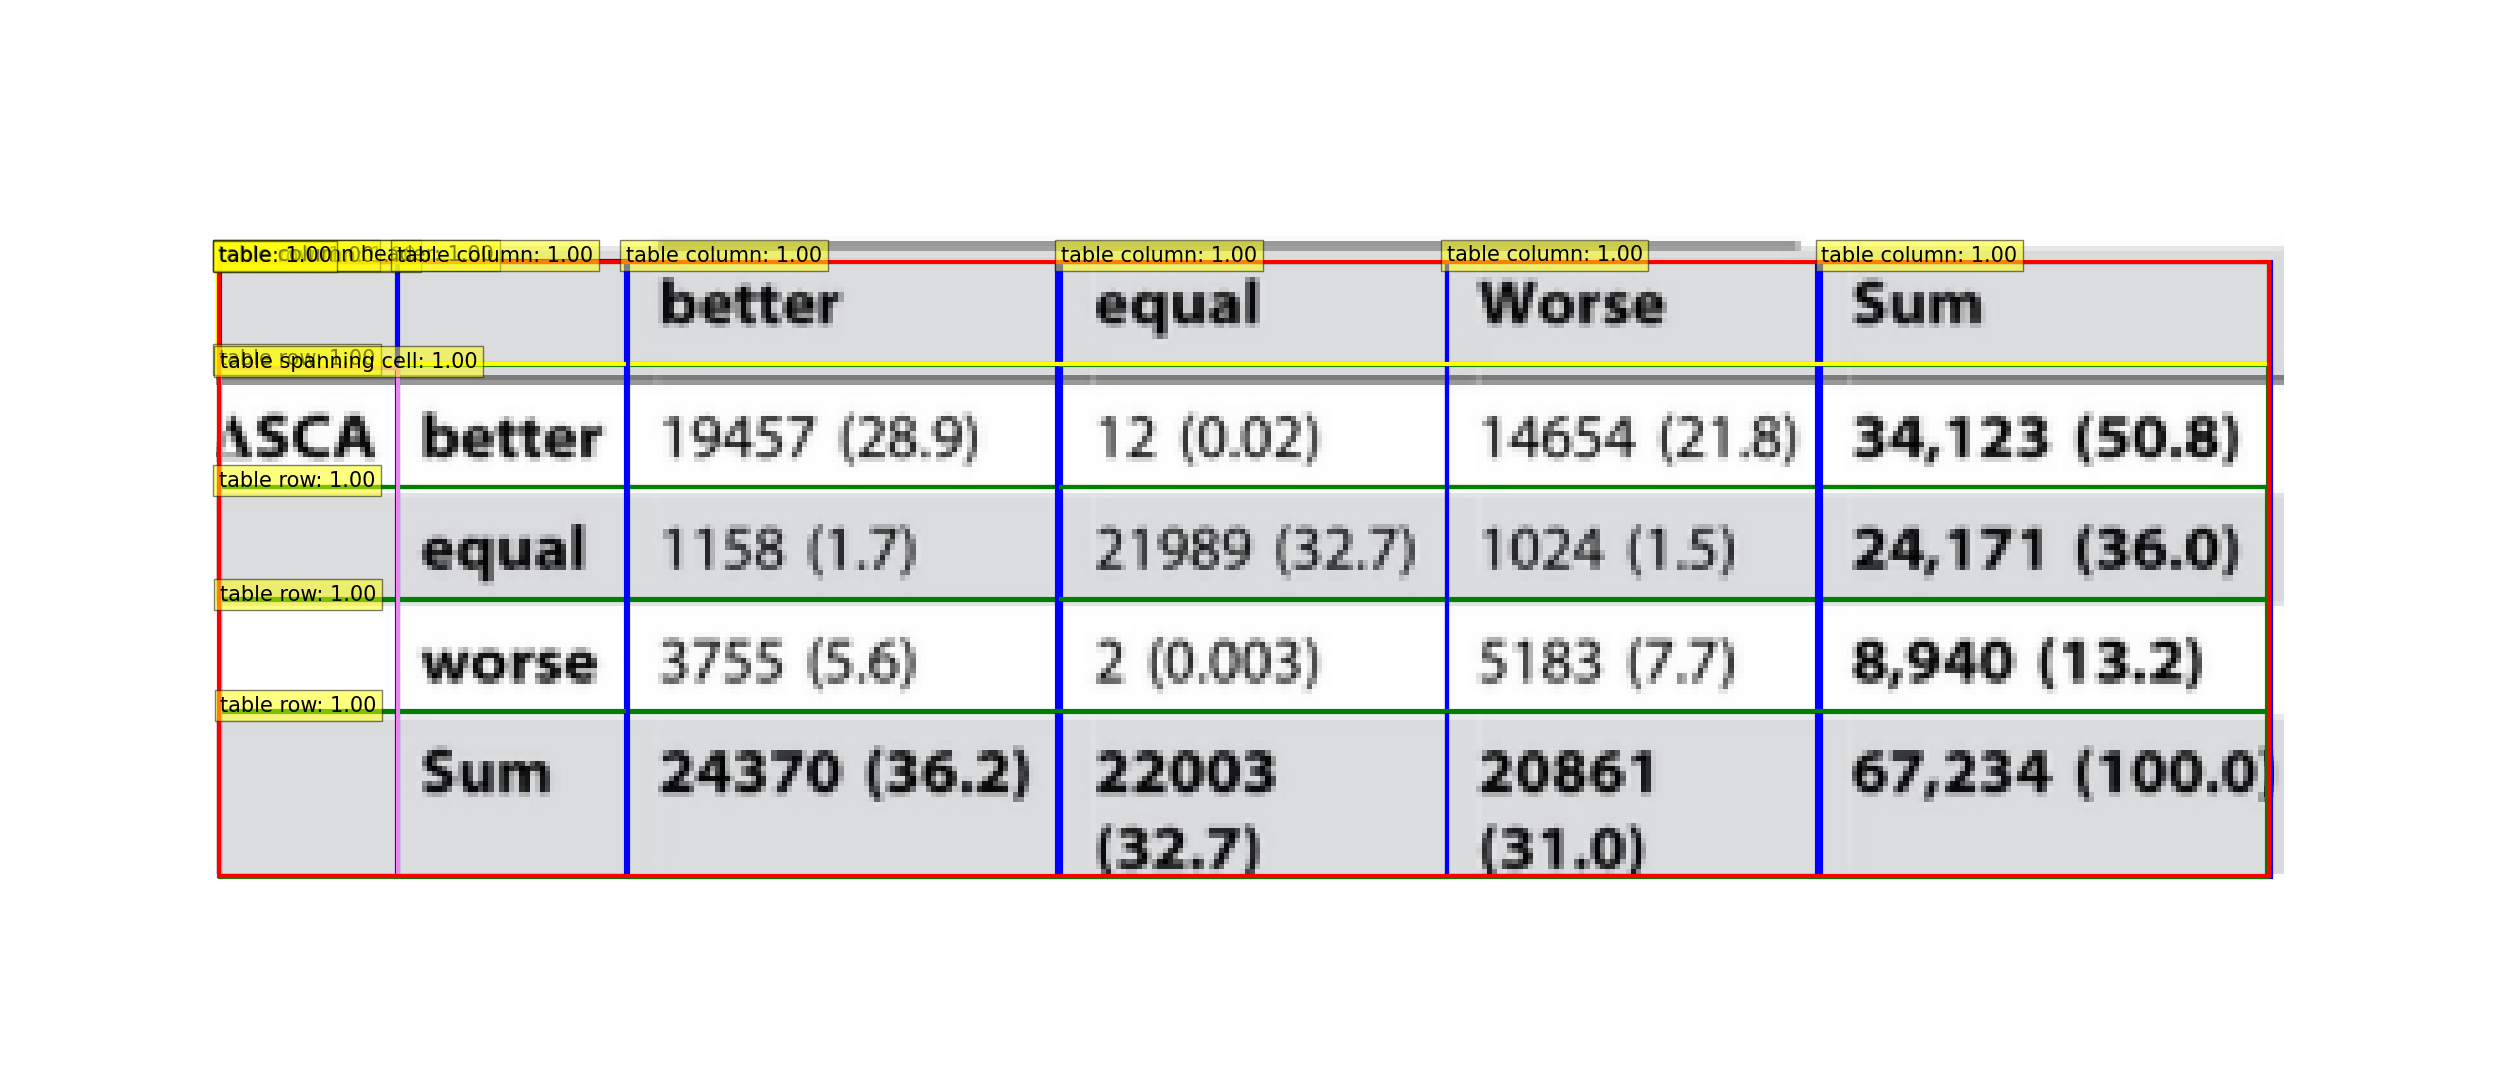

In [9]:
from gmft.table_function import TATRTableFormatter

formatter = TATRTableFormatter()
ft = formatter.extract(tables[0])
ft.visualize()

Since table #1 is an **image**, OCR is required (which you must handle externally.) The image can be obtained through ft.image(), which is a PIL image. This image can then be fed into an OCR of your choice, like paddlepaddle, tesseract, even GPT4-V, etc.

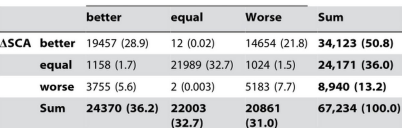

In [17]:
ft.image(dpi=144)

Let's keep going

In [18]:
ft = formatter.extract(tables[1])

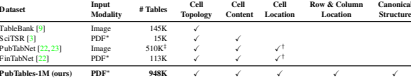

In [19]:
ft.image()

In [20]:
ft.df()

,Dataset,Input Modality,# Tables,Cell Topology,Cell Content,Cell Location,Row & Column Location,Canonical Structure
0,TableBank [9],Image,145K,X,None,None,None,None
1,SciTSR [3],PDF∗,15K,X,X,None,None,None
2,"PubTabNet [22, 23]",Image,510K‡,X,X,X†,None,None
3,FinTabNet [22],PDF∗,113K,X,X,X†,None,None
4,PubTables-1M (ours),PDF∗,948K,X,X,X,X,X


Now that table has text, gmft does quite well.

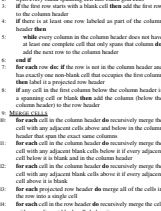

In [11]:
ft = formatter.extract(tables[2])
ft.image(dpi=50)

It looks like table #3 is a false positive. You can see that the confidence score is much lower.

In [12]:
tables[2].label, tables[2].confidence_score

(0, 0.9068530797958374)

Undeterred, let's see tables #4 & #5.

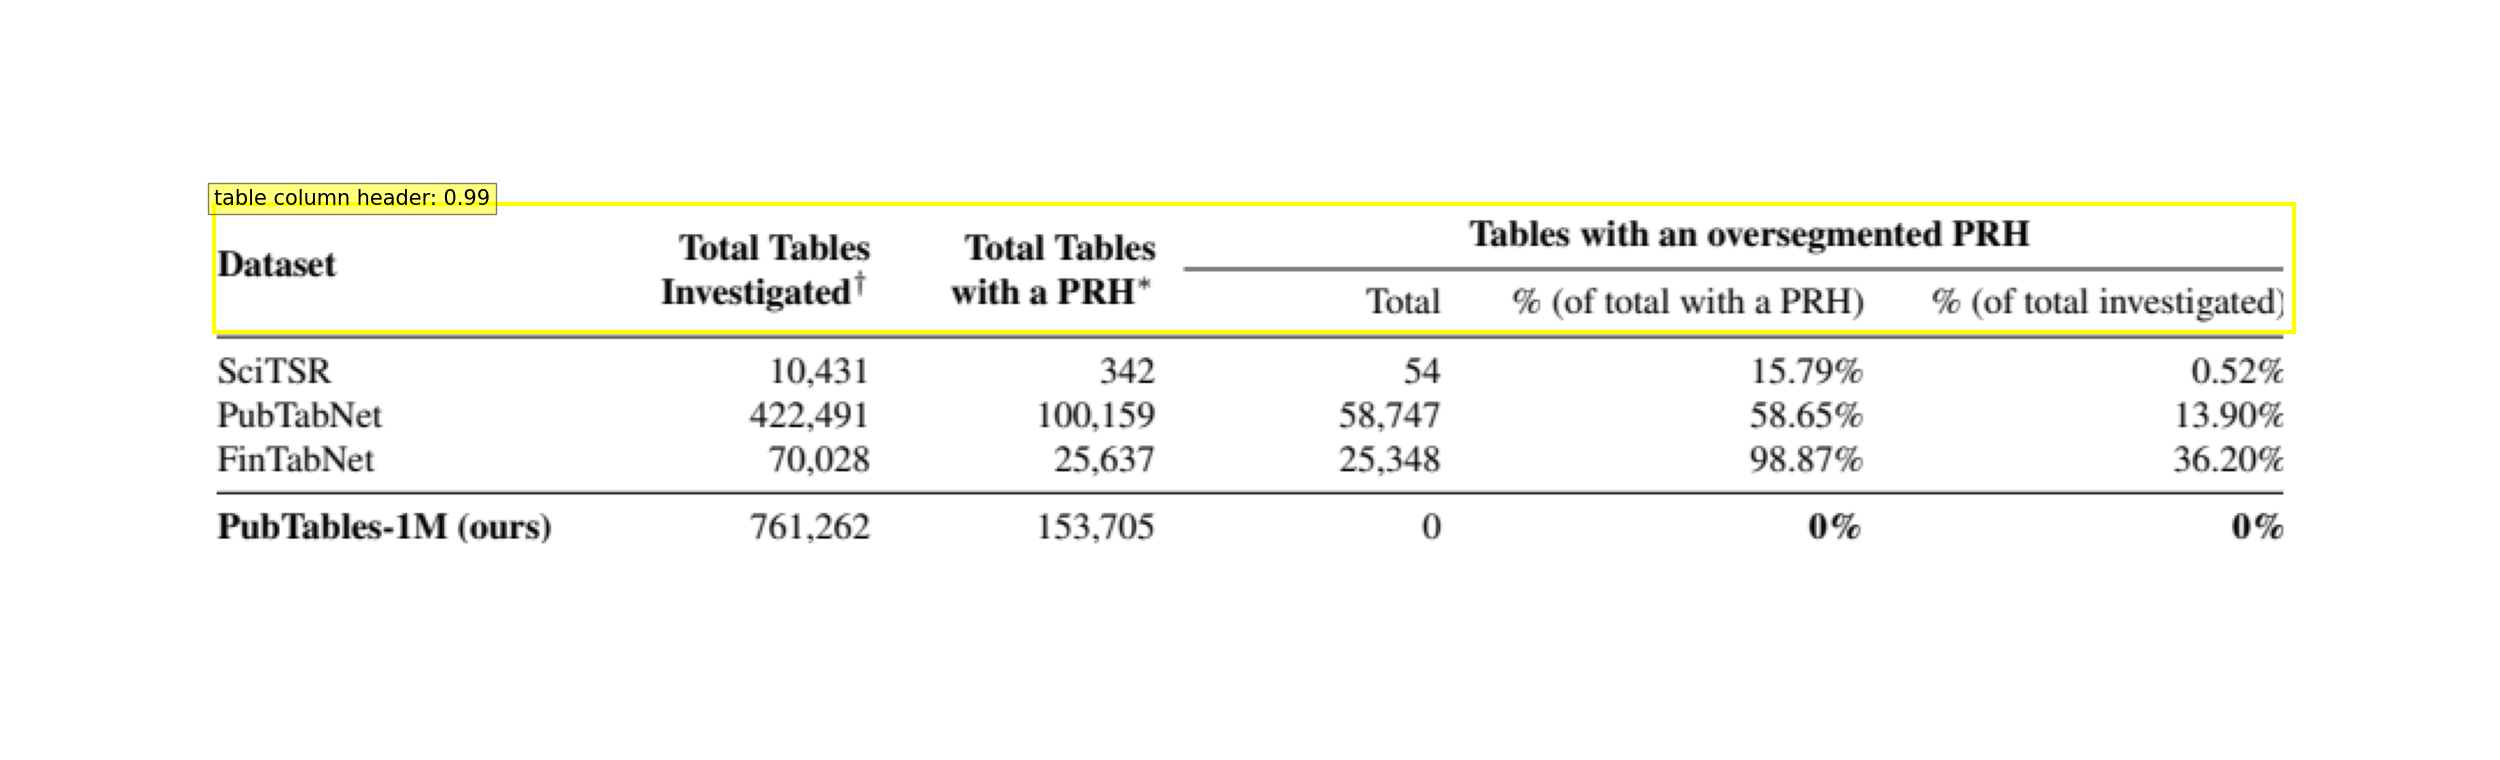

None

,Dataset,Total Tables Investigated†,Total Tables with a PRH∗,Total,Tables with an oversegmented % (of total with a PRH),PRH % (of total investigated)
0,SciTSR,"10,431",342,54,15.79%,0.52%
1,PubTabNet,"422,491","100,159","58,747",58.65%,13.90%
2,FinTabNet,"70,028","25,637","25,348",98.87%,36.20%
3,PubTables-1M (ours),"761,262","153,705",0,0%,0%


In [28]:
from IPython.display import display

ft = formatter.extract(tables[3])
display(ft.visualize(filter=[3]))
ft.df()

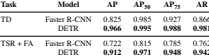

,Task,Model,AP,AP50,AP75,AR
0,TD,Faster R-CNN,0.825,0.985,0.927,0.866
1,None,DETR,0.966,0.995,0.988,0.981
2,TSR + FA,Faster R-CNN,0.722,0.815,0.785,0.762
3,None,DETR,0.912,0.971,0.948,0.942


In [32]:
ft = formatter.extract(tables[4])
display(ft.image())
ft.df()

Important! Once you're done with a document, remember to close it. This is especially important in loops.

In [37]:
doc.close()

Let's look at a difficult table with a lot of rows.

In [36]:
!wget -O ../samples/nmr.pdf http://ccc.chem.pitt.edu/wipf/Web/NMR_Impurities.pdf

--2024-06-07 14:48:58--  http://ccc.chem.pitt.edu/wipf/Web/NMR_Impurities.pdf
Resolving ccc.chem.pitt.edu (ccc.chem.pitt.edu)... 136.142.97.29
Connecting to ccc.chem.pitt.edu (ccc.chem.pitt.edu)|136.142.97.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 543237 (531K) [application/pdf]
Saving to: ‘../samples/nmr.pdf’

../samples/nmr.pdf  100%[===================>] 530.50K  1.71MB/s    in 0.3s    

2024-06-07 14:48:59 (1.71 MB/s) - ‘../samples/nmr.pdf’ saved [543237/543237]



In [40]:
tables, doc = ingest_pdf('../samples/nmr.pdf')
len(tables)

5

In [44]:
print(tables[0].confidence_score)
tables[0].image()

0.9082970023155212


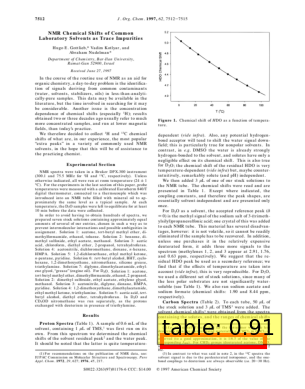

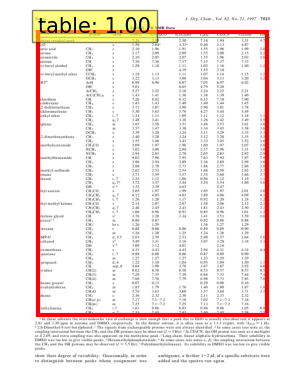

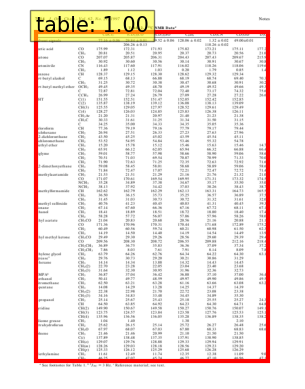

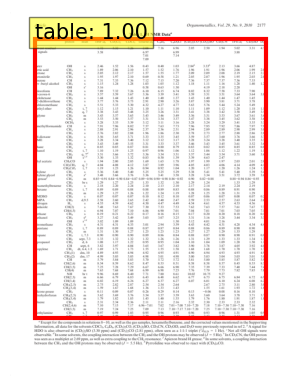

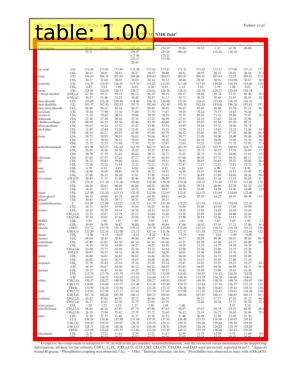

In [45]:
# display several images
for table in tables:
    table.visualize(figsize=None)

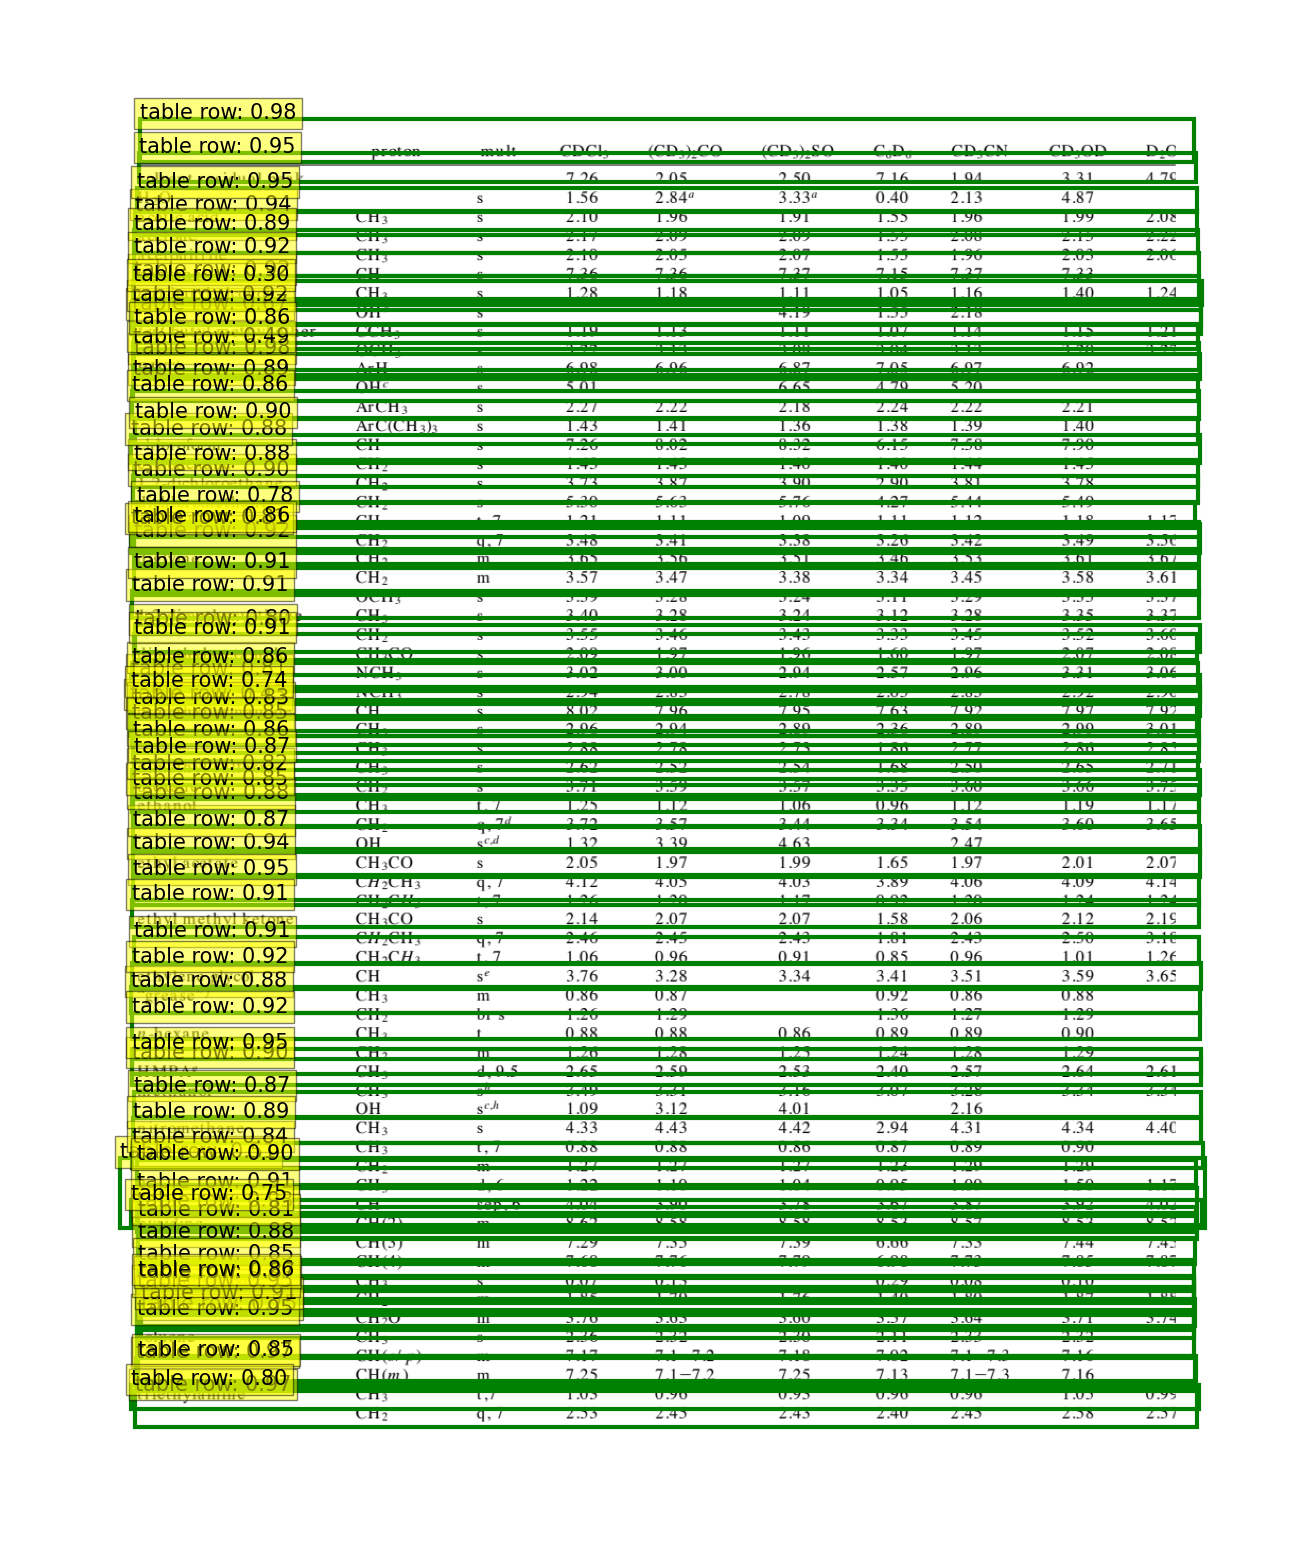

In [49]:
ft1 = formatter.extract(tables[1])
ft1.visualize(filter=[2])

TATR's row detection sometimes struggles for large tables. However, ft.df() is many times still able to give workable results.

In [50]:
ft1.df()

,,pr ot on,m ult,CDCl3,(CD3)2CO,(CD3)2SO,C6D6,CD3CN,CD3OD,D2O,is_spanning_row
0,solvent r esidu al pea k,None,None,7.26,2.05,2.50,7.16,1.94,3.31,4.79,False
1,H2O,None,s,1.56,2.84a,3.33a,0.40,2.13,4.87,None,False
2,a cetic a cid,CH3,s,2.10,1.96,1.91,1.55,1.96,1.99,2.08,False
3,a cet on e,CH3,s,2.17,2.09,2.09,1.55,2.08,2.15,2.22,False
4,a cet onit rile benzene,CH3 CH,s,2.10 7.36,2.05 7.36,2.07 7.37,1.55 7.15,1.96 7.37,2.03 7.33,2.06,False
...,...,...,...,...,...,...,...,...,...,...,...
59,t olu en e,CH3,s,2.36,2.32,2.30,2.11,2.33,2.32,None,False
60,None,CH(o/ p),m,7.17,7.1-7.2,7.18,7.02,7.1-7.3,7.16,None,False
61,None,CH(m ),m,7.25,7.1-7.2,7.25,7.13,7.1-7.3,7.16,None,False
62,triethylamine,CH3,"t,7",1.03,0.96,0.93,0.96,0.96,1.05,0.99,False


Finally, note that false positives may be observed more often for rotated tables ( where `table.label == 1`)

In [64]:
ft.label

0